<a href="https://colab.research.google.com/github/PebbleBuilds/acc-class/blob/base_cnn/Acc_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APS360 Project: Speech Accent Classifier Project

**Members**: 
Catherine Glossop, Julia Chae, Mingshi Chi, Rocco Ruan 



## Set Up

In [ ]:
# package imports 

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 

torch.manual_seed(15)

In [ ]:
# mounting the Google Drive 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# helper functions 

def generate_data():
  data_transform = transforms.Compose([transforms.ToTensor()])
  data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group Project/data_mfcc', transform=data_transform)
  return data

def visualize_data(dataset):
  batch = 27
  num_workers = 1

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

  # Visualize some sample data
  classes = ['english', 'mandarin', 'hindi', 'tagalog']

  # obtain one batch of training images
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.numpy() # convert images to numpy for display

  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title(classes[labels[idx]])

## Preparing & Visualizing Dataset

(27, 3, 480, 640)


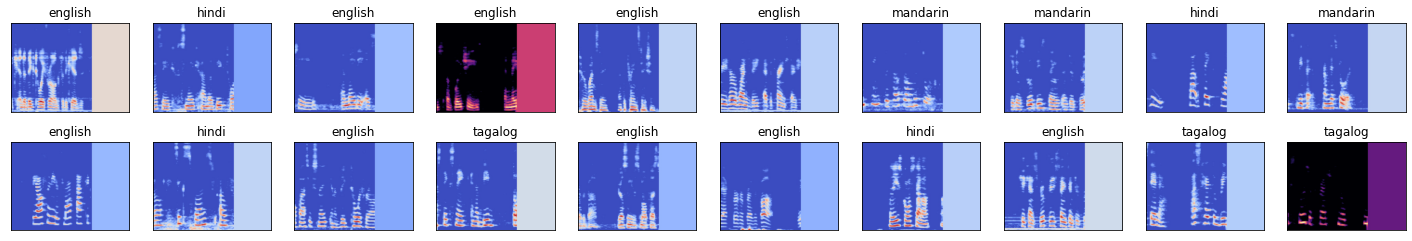

In [ ]:
dataset= generate_data()
visualize_data(dataset)

## Accent Classifier Architecture


In [ ]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier'
          self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(117*157*10, 560)
          self.fc2 = nn.Linear(560, 9)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 117*157*10)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

## Training 

In [ ]:
def train_net(net, batch_size=8, num_workers = 1, learning_rate=0.01, num_epochs=30):
    # Train a classifier on sign language images
    # Fixed PyTorch random seed for reproducible result
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # The loss function will be Cross Entropy and Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in data_loader:
            # Get the inputs
            if torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            out = net(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            print("Iteration: ",n,"Loss: ",loss,'Progress: % 6.2f ' % ((epoch * len(data_loader) + mini_b) / (num_epochs * len(data_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        if (epoch>25):
          model_path = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
          torch.save(net.state_dict(), model_path)
                
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))
    

In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 27
num_epochs = 100
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, num_epochs = num_epochs)